## Import Libraries and Dataset

### Import Libraries

In [26]:
import matplotlib.pyplot as plt 
import matplotlib.dates as md
%matplotlib inline
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np

### Import dataset

In [27]:
#import transaction data (3y transaction history of customers whoe were targeted in the campaign)
df_tx = pd.read_csv('C:/Users/yiche/Desktop/Springboard/Capstone 2/Loyalty Market/LMKM files/transactions.csv')

#assign datetime datatype to TX_DT and set it as index
df_tx['TX_DT'] = df_tx['TX_DT'].astype('datetime64[ns]')
df_tx.set_index('TX_DT', inplace=True)

#filter out rows with sales value lower than 35 as the campaign focused only on sales above $35
#df_tx = df_tx[df_tx.SALES_VALUE >= 35]

#focus on the year 2014 when the campagin occured and other promotion information is provided
df_tx = df_tx.loc['2014']

#print the transaction dataframe and descriptive stats
print(df_tx.head(3))
m1 = '\033[96m Descriptive statistics of Transaction Data:\033[0m\n'
print(m1, df_tx[['QUANTITY_GM', 'SALES_VALUE']].describe().apply(lambda s: s.apply('{0:.5f}'.format)))

            CUSTOMER_ID     TXN_ID   TEA_GRADE  QUANTITY_GM  SALES_VALUE
TX_DT                                                                   
2014-01-03      1618808  247555053  INGREDIENT        112.0        66.03
2014-01-01      2329175  247360288     CLASSIC         58.0        38.08
2014-01-04      6671867  247655436     CLASSIC         70.0        44.98
 Descriptive statistics of Transaction Data:
          QUANTITY_GM    SALES_VALUE
count  1129630.00000  1129630.00000
mean        80.47510       52.26038
std         36.40782       24.24639
min          2.00000        0.48000
25%         58.00000       37.88000
50%         78.00000       50.02000
75%        100.00000       65.00000
max       4368.00000     2772.00000


In [28]:
#To be used for cohort analysis
df2 = pd.read_csv('C:/Users/yiche/Desktop/Springboard/Capstone 2/Loyalty Market/LMKM files/transactions.csv')
#assign datetime datatype to TX_DT and set it as index
df2['TX_DT'] = df2['TX_DT'].astype('datetime64[ns]')
df2.set_index('TX_DT', inplace=True)
df2.head(3)

,CUSTOMER_ID,TXN_ID,TEA_GRADE,QUANTITY_GM,SALES_VALUE
TX_DT,,,,,
2013-02-10,12116720,213446126,CLASSIC,46.0,30.00
2013-04-13,14276524,219825460,CLASSIC,24.0,14.00
2013-03-06,1300766,215433725,CLASSIC,52.0,33.01


In [29]:
#import loyalty campaign data
df_lc = pd.read_csv('C:/Users/yiche/Desktop/Springboard/Capstone 2/Loyalty Market/LMKM files/loyalty_campaign.csv')

#assign datetime datatype to signup_date and first_tx_date
df_lc[['signup_date', 'first_tx_date']] = df_lc[['signup_date', 'first_tx_date']].astype('datetime64[ns]')

#print the customer dataframe and descriptive stats
print(df_lc.head(3))
m2 = '\033[96m Descriptive statistics of Loyalty Campaign Data:\033[0m\n'
print(m2, df_lc.describe().apply(lambda s: s.apply('{0:.5f}'.format)))
print(df_lc.info())

   customer_id signup_date first_tx_date  rank reward_code contact_status  \
0      8484062  2000-09-12    2011-01-10     1        KT49           CNTC   
1     10715155  2004-09-13    2008-09-10     1        KT49           CNTC   
2     13526940  2011-03-17    2011-03-18     1        KT49           CNTC   

   count_issuance  total_leaves  
0             1.0         100.0  
1             1.0         100.0  
2             1.0         100.0  
 Descriptive statistics of Loyalty Campaign Data:
           customer_id          rank count_issuance total_leaves
count    111102.00000  111102.00000    13632.00000  13632.00000
mean   10199740.85993       1.00000        1.64026    261.30428
std     6053564.92852       0.00000        0.94628    266.37248
min         154.00000       1.00000        1.00000    100.00000
25%     4817364.25000       1.00000        1.00000    100.00000
50%    10418252.00000       1.00000        1.00000    100.00000
75%    15590419.00000       1.00000        2.00000    30

All customers in the dataset df_lc are assigned a unique customer_id, and each is in a targeting segment (reward_code being KT49 or KT51). The contact status specifies wether the customer is in the control or target group. 

-------------------

## Data Cleansing

**Adding and dropping columns**

In [30]:
#Add dummy variables that identify each transaction as either belonging to the campaign/promotion period or not
df_tx['tx_campaign_period'] = np.where((df_tx.index >= '2014-11-04') & (df_tx.index <= '2014-12-15'), 1, 0)
df_tx['tx_post_campaign'] = np.where((df_tx.index > '2014-12-15'), 1, 0)
df_tx['tx_mar_promo_period'] = np.where((df_tx.index >= '2014-03-17') & (df_tx.index <= '2014-03-31'), 1, 0)
df_tx['tx_summer_promo_period'] = np.where((df_tx.index >= '2014-04-08') & (df_tx.index <= '2014-06-02'), 1, 0)
df_tx['tx_winter_promo_period'] = np.where((df_tx.index >= '2014-02-14') & (df_tx.index <= '2014-03-16'), 1, 0)
df_tx['tx_sur_promo_period'] = np.where((df_tx.index >= '2014-08-11') & (df_tx.index <= '2014-09-07'), 1, 0)
df_tx['tx_pre_campaign'] = np.where((df_tx.index < '2014-11-04') & (df_tx.tx_mar_promo_period == 0) & (df_tx.tx_summer_promo_period == 0) & (df_tx.tx_winter_promo_period == 0) & (df_tx.tx_sur_promo_period == 0), 1, 0)

In [31]:
#Add sales during campaign period and sales pre campaign columns
df_tx['campaign_sales'] = df_tx.tx_campaign_period * df_tx.SALES_VALUE
df_tx['pre_campaign_sales'] = df_tx.tx_pre_campaign * df_tx.SALES_VALUE
df_tx['post_campaign_sales'] = df_tx.tx_post_campaign * df_tx.SALES_VALUE

In [32]:
#Add 'margin' column
"""
Classic $0.15
Ingredient $0.18
Premium $0.20
Ceremonial $0.30
"""

conditions = [
    (df_tx['TEA_GRADE'] == 'CLASSIC'),
    (df_tx['TEA_GRADE'] == 'INGREDIENT'), 
    (df_tx['TEA_GRADE'] == 'PREMIUM'), 
    (df_tx['TEA_GRADE'] == 'CEREMONIAL')
    ]

# create a list of the values we want to assign for each condition
values = [df_tx['QUANTITY_GM']*0.15, df_tx['QUANTITY_GM']*0.18, df_tx['QUANTITY_GM']*0.20, df_tx['QUANTITY_GM']*0.30]

# create a new column and use np.select to assign values to it using our lists as arguments
df_tx['margin'] = np.select(conditions, values)
df_tx['margin_campaign'] = df_tx['margin']*df_tx['tx_campaign_period']
df_tx['margin_precampaign'] = df_tx['margin']*df_tx['tx_pre_campaign']

In [33]:
#Add 'regular leaf cost' column
"""
Classic 1/3
Ingredient 2/3
Premium 3/3
Ceremonial 4/3
"""

conditions = [
    (df_tx['TEA_GRADE'] == 'CLASSIC'),
    (df_tx['TEA_GRADE'] == 'INGREDIENT'), 
    (df_tx['TEA_GRADE'] == 'PREMIUM'), 
    (df_tx['TEA_GRADE'] == 'CEREMONIAL')
    ]

# create a list of the values we want to assign for each condition
values = [df_tx['SALES_VALUE']*1/3, df_tx['SALES_VALUE']*2/3, df_tx['SALES_VALUE']*1, df_tx['SALES_VALUE']*4/3]

# create a new column and use np.select to assign values to it using our lists as arguments
df_tx['regular_leaves_issuance'] = np.select(conditions, values)
df_tx['regular_leaves_cost'] = df_tx.regular_leaves_issuance * 0.0925
df_tx['regular_leaf_cost_campaign'] = df_tx['regular_leaves_cost']*df_tx['tx_campaign_period']
df_tx['regular_leaf_cost_precampaign'] = df_tx['regular_leaves_cost']*df_tx['tx_pre_campaign']
df_tx.head(3)

,CUSTOMER_ID,TXN_ID,TEA_GRADE,QUANTITY_GM,SALES_VALUE,tx_campaign_period,tx_post_campaign,tx_mar_promo_period,tx_summer_promo_period,tx_winter_promo_period,...,campaign_sales,pre_campaign_sales,post_campaign_sales,margin,margin_campaign,margin_precampaign,regular_leaves_issuance,regular_leaves_cost,regular_leaf_cost_campaign,regular_leaf_cost_precampaign
TX_DT,,,,,,,,,,,,,,,,,,,,,
2014-01-03,1618808,247555053,INGREDIENT,112.0,66.03,0,0,0,0,0,...,0.0,66.03,0.0,20.16,0.0,20.16,44.020000,4.071850,0.0,4.071850
2014-01-01,2329175,247360288,CLASSIC,58.0,38.08,0,0,0,0,0,...,0.0,38.08,0.0,8.70,0.0,8.70,12.693333,1.174133,0.0,1.174133
2014-01-04,6671867,247655436,CLASSIC,70.0,44.98,0,0,0,0,0,...,0.0,44.98,0.0,10.50,0.0,10.50,14.993333,1.386883,0.0,1.386883


In [37]:
df_tx.reset_index(inplace=True)
df_tx.to_csv(r'C:\Users\yiche\Desktop\Springboard\Capstone 2\sales_margin.csv')

In [9]:
#Aggregate the transaction table to customer level
df_tx1 = df_tx.groupby('CUSTOMER_ID').sum().drop(columns = 'TXN_ID')
df_tx1.tail()

,QUANTITY_GM,SALES_VALUE,tx_campaign_period,tx_post_campaign,tx_mar_promo_period,tx_summer_promo_period,tx_winter_promo_period,tx_sur_promo_period,tx_pre_campaign,campaign_sales,pre_campaign_sales,post_campaign_sales,margin,margin_campaign,margin_precampaign,regular_leaves_issuance,regular_leaves_cost,regular_leaf_cost_campaign,regular_leaf_cost_precampaign
CUSTOMER_ID,,,,,,,,,,,,,,,,,,,
21025530,1734.0,1124.23,2,1,2,7,4,1,6,74.76,282.66,34.04,269.70,20.70,66.30,424.743333,39.288758,2.305100,8.715350
21027651,1272.0,986.05,0,0,1,6,2,1,10,0.00,460.02,0.00,254.40,0.00,118.40,986.050000,91.209625,0.000000,42.551850
21031437,634.0,386.87,0,0,1,3,2,0,1,0.00,50.63,0.00,97.56,0.00,14.76,145.833333,13.489583,0.000000,3.122183
21042309,802.0,542.99,1,0,0,6,3,1,2,42.99,90.00,0.00,120.30,11.40,19.80,180.996667,16.742192,1.325525,2.775000
21064154,192.0,120.04,1,1,0,0,1,1,1,20.01,20.04,19.99,34.56,6.48,5.76,80.026667,7.402467,1.233950,1.235800


**Merging the two datasets**

In [10]:
df_lc.set_index('customer_id', inplace=True)
df = pd.merge(df_lc, df_tx1, left_index=True, right_index=True)

**Creating new columns for the final dataset**

In [11]:
#Add cost per Uji leaf arising from the loyalty Campaign ($0.0925)
df['bonus_leaf_cost'] = df['total_leaves']*0.0925
df['bonus_leaf_cost'] = df['bonus_leaf_cost'].fillna(0)

#Add dummy variables for testing group
df['target_group'] = np.where((df.contact_status == 'CNTC'), 1, 0)

#Add dummy variables for KT51
df['KT51'] = np.where((df.reward_code == 'KT51'), 1, 0)

#Add dummy variables for respond to the campaign
df['KT49_respond'] = np.where((df.reward_code == 'KT49') & (df.tx_campaign_period > 0), 1, 0)
df['KT51_respond'] = np.where((df.reward_code == 'KT51') & (df.tx_campaign_period > 0), 1, 0)

#Number of customer respond to the campaign and received leaf
df['respond'] = np.where((df.count_issuance > 0), 1, 0)

#Each period has different lengh, divide the number of weeks of each period to get average number of transactions per week
df['weekly_tx_campaign_period'] = df.tx_campaign_period / 6
df['weekly_campaign_sales'] = df.campaign_sales / 6
df['weekly_tx_pre_campaign'] = df.tx_pre_campaign / 25.5 #(52-6-2.5-2-8-4-4)
df['weekly_pre_campaign_sales'] = df.pre_campaign_sales / 25.5
df['weekly_tx_post_campaign'] = df.tx_post_campaign / 2.5
df['weekly_post_campaign_sales'] = df.post_campaign_sales / 2.5
# df['weekly_tx_mar_promo_period'] = df.tx_mar_promo_period / 2
# df['weekly_tx_summer_promo_period'] = df.tx_summer_promo_period / 8
# df['weekly_tx_winter_promo_period'] = df.tx_winter_promo_period / 4
# df['weekly_tx_sur_promo_period'] = df.tx_sur_promo_period / 4

df.tail(3)

,signup_date,first_tx_date,rank,reward_code,contact_status,count_issuance,total_leaves,QUANTITY_GM,SALES_VALUE,tx_campaign_period,...,KT51,KT49_respond,KT51_respond,respond,weekly_tx_campaign_period,weekly_campaign_sales,weekly_tx_pre_campaign,weekly_pre_campaign_sales,weekly_tx_post_campaign,weekly_post_campaign_sales
3953161,1992-03-18,2004-10-15,1,KT49,CNTC,NaN,NaN,428.0,305.05,1,...,0,1,0,0,0.166667,5.503333,0.117647,5.412941,0.0,0.0
1832334,1994-10-26,2005-07-13,1,KT49,CNTC,NaN,NaN,40.0,25.20,0,...,0,0,0,0,0.000000,0.000000,0.078431,0.988235,0.0,0.0
14631070,2008-02-29,2010-06-26,1,KT49,CNTC,NaN,NaN,78.0,53.91,0,...,0,0,0,0,0.000000,0.000000,0.039216,2.114118,0.0,0.0


In [12]:
#drop columns not going to be used
df.drop(columns = ['rank', 'signup_date', 'first_tx_date', 'tx_campaign_period', 'tx_post_campaign', 'tx_mar_promo_period', 'tx_summer_promo_period', 'tx_winter_promo_period', 'tx_sur_promo_period', 'tx_pre_campaign', 'post_campaign_sales', 'total_leaves', 'QUANTITY_GM', 'weekly_tx_post_campaign','weekly_post_campaign_sales'], inplace= True)
print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111048 entries, 8484062 to 14631070
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   reward_code                    111048 non-null  object 
 1   contact_status                 111048 non-null  object 
 2   count_issuance                 13632 non-null   float64
 3   SALES_VALUE                    111048 non-null  float64
 4   campaign_sales                 111048 non-null  float64
 5   pre_campaign_sales             111048 non-null  float64
 6   margin                         111048 non-null  float64
 7   margin_campaign                111048 non-null  float64
 8   margin_precampaign             111048 non-null  float64
 9   regular_leaves_issuance        111048 non-null  float64
 10  regular_leaves_cost            111048 non-null  float64
 11  regular_leaf_cost_campaign     111048 non-null  float64
 12  regular_leaf_cost_prec

,reward_code,contact_status,count_issuance,SALES_VALUE,campaign_sales,pre_campaign_sales,margin,margin_campaign,margin_precampaign,regular_leaves_issuance,...,bonus_leaf_cost,target_group,KT51,KT49_respond,KT51_respond,respond,weekly_tx_campaign_period,weekly_campaign_sales,weekly_tx_pre_campaign,weekly_pre_campaign_sales
8484062,KT49,CNTC,1.0,593.64,125.47,233.81,131.4,32.4,48.9,197.880000,...,9.25,1,0,1,0,1,0.333333,20.911667,0.117647,9.169020
10715155,KT49,CNTC,1.0,377.72,102.71,125.04,87.9,26.1,27.9,125.906667,...,9.25,1,0,1,0,1,0.333333,17.118333,0.078431,4.903529
13526940,KT49,CNTC,1.0,627.07,138.00,161.50,149.1,34.2,35.1,266.403333,...,9.25,1,0,1,0,1,0.666667,23.000000,0.117647,6.333333


In [22]:
df.to_csv(r'C:\Users\yiche\Desktop\Springboard\Capstone 2\df.csv', index = False)

-------------------

## Exploratory Data Analysis

***Statistical summary***

In [13]:
df.describe()

,count_issuance,SALES_VALUE,campaign_sales,pre_campaign_sales,margin,margin_campaign,margin_precampaign,regular_leaves_issuance,regular_leaves_cost,regular_leaf_cost_campaign,...,bonus_leaf_cost,target_group,KT51,KT49_respond,KT51_respond,respond,weekly_tx_campaign_period,weekly_campaign_sales,weekly_tx_pre_campaign,weekly_pre_campaign_sales
count,13632.000000,111048.000000,111048.000000,111048.000000,111048.000000,111048.000000,111048.000000,111048.000000,111048.000000,111048.000000,...,111048.000000,111048.000000,111048.000000,111048.000000,111048.000000,111048.000000,111048.000000,111048.000000,111048.000000,111048.000000
mean,1.640258,531.615952,55.094951,252.848916,129.955462,15.347156,60.893827,237.131442,21.934658,2.309813,...,2.967134,0.949805,0.406005,0.240608,0.291126,0.122758,0.189646,9.182492,0.186673,9.915644
std,0.946280,398.709747,81.293574,211.868545,100.228884,22.727339,51.966159,246.732968,22.822800,4.115901,...,11.723309,0.218347,0.491088,0.427454,0.454284,0.328160,0.254227,13.548929,0.143797,8.308570
min,1.000000,3.000000,0.000000,0.000000,0.600000,0.000000,0.000000,1.000000,0.092500,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,203.462500,0.000000,85.997500,48.900000,0.000000,20.520000,76.041667,7.033854,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078431,3.372451
50%,1.000000,439.320000,27.010000,200.785000,106.310000,7.500000,48.000000,169.700000,15.697250,0.894167,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.166667,4.501667,0.156863,7.873922
75%,2.000000,788.600000,85.010000,378.772500,190.900000,23.700000,90.600000,309.056667,28.587742,3.083333,...,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.333333,14.168333,0.274510,14.853824
max,4.000000,6881.680000,3600.000000,6684.710000,1932.800000,852.600000,1273.500000,5344.190000,494.337575,131.710133,...,92.500000,1.000000,1.000000,1.000000,1.000000,1.000000,7.666667,600.000000,1.725490,262.145490


### Customer Lifetime Value

CLTV = (ACV * ACL * GM * retention) / (1 + 0.1 - retention)
<br>ACV(Average customer value) = APV (Average purchase value) * APFR(Average purchase frequency rate)
<br>ACL(Average customer lifespan) = 1 / (1 - retention)
<br>0.1 is the rough annual inflation rate

In [14]:
#CLTV in 2012 2013 2014
def SCN(a, b, c, d=0.24445365330032742):
    ACV = a*b
    ACL = 1/(1-c)
    result = (ACV * ACL * d * c)/(1.1-c)
    return result

In [15]:
#CLTV2012
APV12 = df2.loc['2012']['SALES_VALUE'].mean()
APFR12 = df2.loc['2012']['SALES_VALUE'].count() / df2.loc['2012']['CUSTOMER_ID'].nunique()
retention12 = 0.70
#CLTV2013
APV13 = df2.loc['2013']['SALES_VALUE'].mean()
APFR13 = df2.loc['2013']['SALES_VALUE'].count() / df2.loc['2013']['CUSTOMER_ID'].nunique()
retention13 = 0.76
#CLTV2014
APV14 = df2.loc['2014']['SALES_VALUE'].mean()
APFR14 = df2.loc['2014']['SALES_VALUE'].count() / df2.loc['2014']['CUSTOMER_ID'].nunique()
retention14 = 0.679

In [16]:
CLTV12=SCN(APV12, APFR12, retention12)
CLTV13=SCN(APV13, APFR13, retention13)
CLTV14=SCN(APV14, APFR14, retention14)
print(CLTV12, CLTV13, CLTV14)

1037.12259881143 1471.523491621165 652.9458745153693


In [17]:
df2.reset_index(inplace=True)

In [19]:
dict = {
    'Year':['2012', '2013', '2014'],
    'APV':[APV12, APV13, APV14],
    'APFR':[APFR12, APFR13, APFR14,],
    'Retention':[retention12 ,retention13 ,retention14],
    'CLTV':[CLTV12, CLTV13, CLTV14]}

dfs = pd.DataFrame.from_dict(dict)
# dfs.set_index('Year', inplace=True)

In [20]:
dfs

,Year,APV,APFR,Retention,CLTV
0,2012,51.429331,14.141839,0.700,1037.122599
1,2013,51.711069,12.498668,0.760,1471.523492
2,2014,52.260376,10.172448,0.679,652.945875


In [21]:
dfs.to_csv(r'C:\Users\yiche\Desktop\Springboard\Capstone 2\cltv.csv', index = False)

### RFM Analysis - Recency, Frequency, and Monetary Value

***Response rate for segment KT49 and KT51 as an indication of customer recency***

In [525]:
#Calculating Average Campaign response rate for KT49 and KT51
RSPR = df.groupby(['reward_code', 'contact_status']).agg({'KT49_respond':'mean', 'KT51_respond':'mean'})
RSPR['respond_rate'] = RSPR.KT49_respond + RSPR.KT51_respond
RSPR = RSPR.drop(['KT49_respond', 'KT51_respond'], 1)
Rtable = pd.pivot_table(RSPR,index='reward_code', columns='contact_status')

In [526]:
#Campaign response rate lift
Rtable['Diff_CNTC-CTRL'] = (Rtable.iloc[:,0]-Rtable.iloc[:,1])/Rtable.iloc[:,1]
Rtable

respond_rate           Diff_CNTC-CTRL
contact_status         CNTC      CTRL               
reward_code                                         
KT49               0.405242  0.401751       0.008690
KT51               0.717268  0.712959       0.006044

Text(0, 0.5, 'response rate')

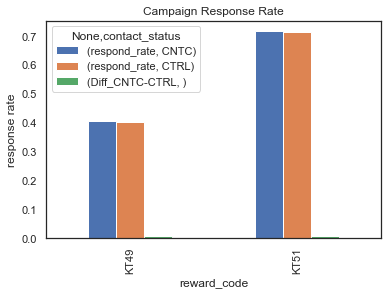

In [527]:
Rtable.plot(kind='bar')
plt.title('Campaign Response Rate')
plt.ylabel('response rate')

In [496]:
df['recency'] = df['KT49_respond'] + df['KT51_respond']

In [498]:
X = df[['KT51', 'target_group', 'weekly_tx_pre_campaign', 'weekly_tx_campaign_period']]
y = df['recency']

X = sm.add_constant(X)
model = sm.OLS(y, X)
modelResult = model.fit()
modelResult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                recency   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 2.761e+04
Date:                Tue, 29 Dec 2020   Prob (F-statistic):               0.00
Time:                        14:47:56   Log-Likelihood:                -42042.
No. Observations:              111048   AIC:                         8.409e+04
Df Residuals:                  111043   BIC:                         8.414e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2379      0.005     48.327      0.000       0.228       0.248
KT51                          0.0453      0.003     15.888      0.000       0.040       0.051
target_group                 -0.0128      0.005     -2.644      0.008      -0.022      -0.003
weekly_tx_pre_campaign        0.2385      0.010     22.942      0.000       0.218       0.259
weekly_tx_campaign_period     1.2819      0.005    271.441      0.000       1.273       1.291
==============================================================================
Omnibus:                    16337.225   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           204493.222
Skew:                          -0.283   Prob(JB):                         0.00
Kurtosis:                       9.624   Cond. No.                         15.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

--------------------

***Purchase frequency of segment KT49 and KT51***

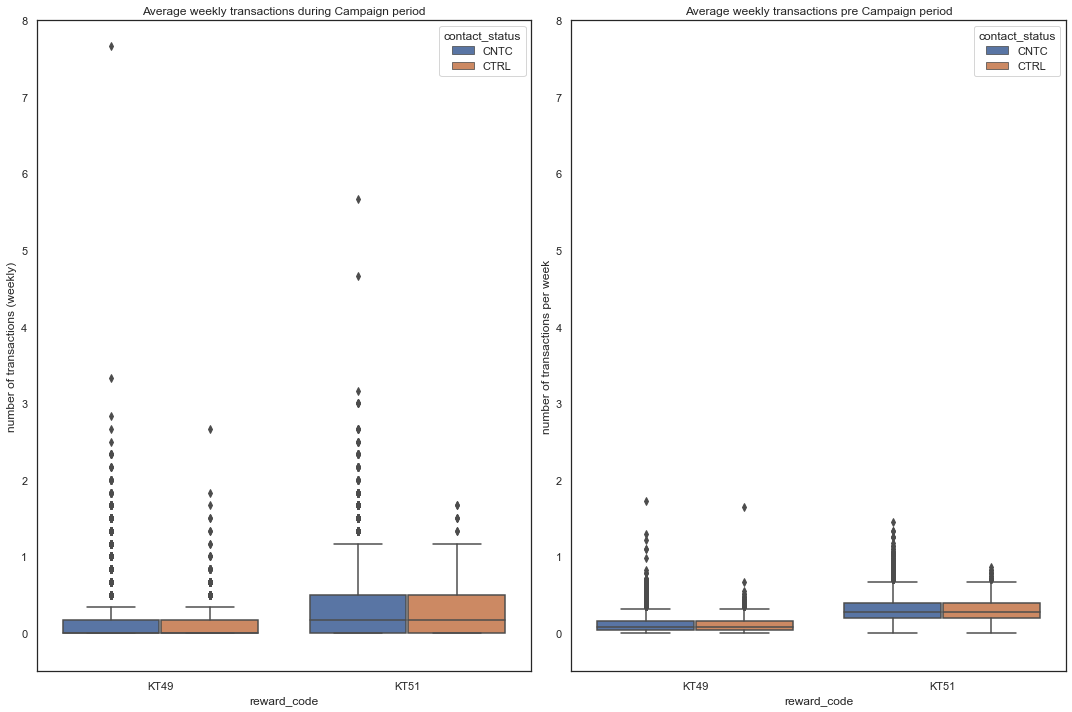

In [570]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
sns.boxplot(x='reward_code', y='weekly_tx_campaign_period', data=df, hue='contact_status')
plt.title('Average weekly transactions during Campaign period')
plt.ylabel('number of transactions (weekly)')
plt.ylim(-0.5, 8)

plt.subplot(1,2,2)
sns.boxplot(x='reward_code', y='weekly_tx_pre_campaign', data=df, hue='contact_status')
plt.title('Average weekly transactions pre Campaign period')
plt.ylabel('number of transactions per week')
plt.ylim(-0.5, 8)

plt.tight_layout()

In [506]:
PFQ = df.groupby(['reward_code', 'contact_status']).agg({'weekly_tx_pre_campaign': 'mean', 'weekly_tx_campaign_period': 'mean'})
PFQ.reset_index(inplace=True)
PFQ['difference']=PFQ.weekly_tx_campaign_period - PFQ.weekly_tx_pre_campaign
PFQ['Frequency Lift Rate (FLR)']=(PFQ.difference/PFQ.weekly_tx_pre_campaign)*100
PFQ.head(4)

,reward_code,contact_status,weekly_tx_pre_campaign,weekly_tx_campaign_period,difference,Frequency Lift Rate (FLR)
0,KT49,CNTC,0.109177,0.120031,0.010854,9.941605
1,KT49,CTRL,0.106355,0.112184,0.005830,5.481358
2,KT51,CNTC,0.300543,0.293010,-0.007532,-2.506292
3,KT51,CTRL,0.294872,0.274289,-0.020583,-6.980472


In [507]:
X = df[['KT51', 'target_group', 'weekly_campaign_sales', 'weekly_tx_pre_campaign', 'weekly_pre_campaign_sales']]
y = df['weekly_tx_campaign_period']

X = sm.add_constant(X)
model = sm.OLS(y, X)
modelResult = model.fit()
modelResult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     weekly_tx_campaign_period   R-squared:                       0.846
Model:                                   OLS   Adj. R-squared:                  0.846
Method:                        Least Squares   F-statistic:                 1.222e+05
Date:                       Tue, 29 Dec 2020   Prob (F-statistic):               0.00
Time:                               15:00:40   Log-Likelihood:                 98475.
No. Observations:                     111048   AIC:                        -1.969e+05
Df Residuals:                         111042   BIC:                        -1.969e+05
Df Model:                                  5                                         
Covariance Type:                   nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0057      0.001      4.090      0.000       0.003       0.008
KT51                          0.0039      0.001      4.658      0.000       0.002       0.006
target_group                  0.0022      0.001      1.595      0.111      -0.001       0.005
weekly_campaign_sales         0.0168   2.51e-05    672.277      0.000       0.017       0.017
weekly_tx_pre_campaign        0.7477      0.004    175.263      0.000       0.739       0.756
weekly_pre_campaign_sales    -0.0115    7.8e-05   -147.354      0.000      -0.012      -0.011
==============================================================================
Omnibus:                   158975.889   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1447784801.182
Skew:                          -7.351   Prob(JB):                         0.00
Kurtosis:                     562.181   Cond. No.                         275.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Difference in differences analysis

In [505]:
#The before and after analysis misses a comparison base. Use the control group to control for unknown differences.
PFQ.drop(columns = ['weekly_tx_pre_campaign', 'weekly_tx_campaign_period', 'difference'], inplace = True)
table = pd.pivot_table(PFQ,index='reward_code', columns='contact_status')
table['FLR_CTRL'] = table.iloc[:,0]-table.iloc[:,1]
table

Frequency lift rate (FLR)            FLR_CTRL
contact_status                      CNTC      CTRL          
reward_code                                                 
KT49                            9.941605  5.481358  4.460247
KT51                           -2.506292 -6.980472  4.474180

Text(0, 0.5, 'purchase frequency lift (%)')

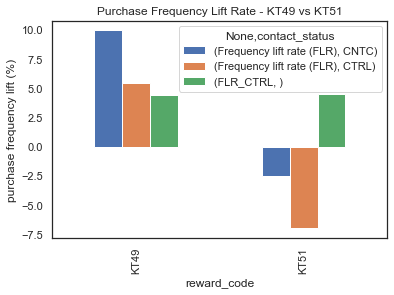

In [508]:
table.plot(kind='bar')
plt.title('Purchase Frequency Lift Rate - KT49 vs KT51')
plt.ylabel('purchase frequency lift (%)')

-------------

***Monetary Value of segment KT49 and KT51***

In [534]:
MV = df.groupby(['reward_code', 'contact_status']).agg({'weekly_campaign_sales': 'mean', 'weekly_pre_campaign_sales': 'mean'})
MV.reset_index(inplace=True)
MV

,reward_code,contact_status,weekly_campaign_sales,weekly_pre_campaign_sales
0,KT49,CNTC,5.427654,5.293770
1,KT49,CTRL,5.066928,5.179147
2,KT51,CNTC,14.739658,16.694638
3,KT51,CTRL,13.997194,16.522162


In [535]:
MV['difference']=MV.weekly_campaign_sales - MV.weekly_pre_campaign_sales
MV['Revenue_Lift_Rate_(RLR)']=(MV.difference/MV.weekly_pre_campaign_sales)*100
MV

,reward_code,contact_status,weekly_campaign_sales,weekly_pre_campaign_sales,difference,Revenue_Lift_Rate_(RLR)
0,KT49,CNTC,5.427654,5.293770,0.133884,2.529086
1,KT49,CTRL,5.066928,5.179147,-0.112220,-2.166759
2,KT51,CNTC,14.739658,16.694638,-1.954980,-11.710227
3,KT51,CTRL,13.997194,16.522162,-2.524969,-15.282314


In [536]:
MV.drop(columns = ['weekly_campaign_sales', 'weekly_pre_campaign_sales', 'difference'], inplace = True)
Mtable = pd.pivot_table(MV,index='reward_code', columns='contact_status')
Mtable['RLR_CTRL'] = Mtable.iloc[:,0] - Mtable.iloc[:,1]
Mtable

Revenue_Lift_Rate_(RLR)             RLR_CTRL
contact_status                    CNTC       CTRL          
reward_code                                                
KT49                          2.529086  -2.166759  4.695845
KT51                        -11.710227 -15.282314  3.572087

In [541]:
X = df[['KT51', 'target_group', 'weekly_tx_campaign_period', 'weekly_tx_pre_campaign']]
y = df['weekly_campaign_sales']

X = sm.add_constant(X)
model = sm.OLS(y, X)
modelResult = model.fit()
modelResult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     weekly_campaign_sales   R-squared:                       0.806
Model:                               OLS   Adj. R-squared:                  0.806
Method:                    Least Squares   F-statistic:                 1.150e+05
Date:                   Tue, 29 Dec 2020   Prob (F-statistic):               0.00
Time:                           15:28:29   Log-Likelihood:            -3.5608e+05
No. Observations:                 111048   AIC:                         7.122e+05
Df Residuals:                     111043   BIC:                         7.122e+05
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.3905      0.083      4.691      0.000       0.227       0.554
KT51                          2.2032      0.048     45.655      0.000       2.109       2.298
target_group                 -0.0475      0.082     -0.578      0.563      -0.208       0.113
weekly_tx_campaign_period    47.9257      0.080    600.095      0.000      47.769      48.082
weekly_tx_pre_campaign       -6.1410      0.176    -34.934      0.000      -6.486      -5.796
==============================================================================
Omnibus:                   211875.193   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3189013971.421
Skew:                          13.971   Prob(JB):                         0.00
Kurtosis:                     832.721   Cond. No.                         15.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(-0.1, 1.0)

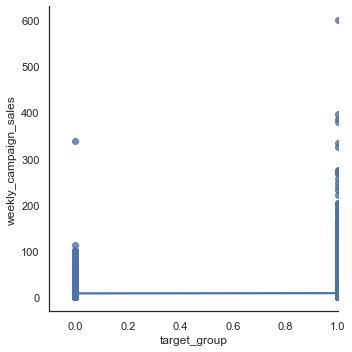

In [572]:
sns.lmplot(x='target_group', y='weekly_campaign_sales', data=df)
plt.xlim(-0.1, 1)

Text(0, 0.5, 'revenue lift rate (%)')

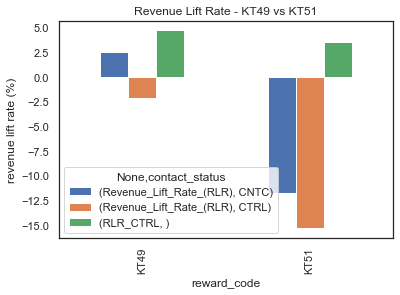

In [537]:
Mtable.plot(kind='bar')
plt.title('Revenue Lift Rate - KT49 vs KT51')
plt.ylabel('revenue lift rate (%)')

------------------------

### Campaign ROI

**Overall Campaign ROI**

***Campaign margin lift***

In [573]:
#Campaign gross margin
def GM(a, b, c, d):
    multiplier = 6/25.5
    trial = sum(a) - sum(b)
    pre = sum(c-d)*multiplier
    result = trial - pre
    return result

GMC = GM(df.margin_campaign, df.regular_leaf_cost_campaign, df.margin_precampaign, df.regular_leaf_cost_precampaign)
print(GMC)

129229.80646373052


***Campaign Investment (Costs)***

In [574]:
#Campsign total costs
def CC(a, b):
    multiplier = 0
    result = sum(a)*multiplier + sum(b)
    return result
    
TCC = CC(df.campaign_sales, df.bonus_leaf_cost)
print(TCC)

329494.25


In [575]:
ROI = round((GMC - TCC) / TCC, 3)*100
print('Campaign ROI: '+str(ROI)+'%')

Campaign ROI: -60.8%


***KT49 and KT 51 Campaign ROI***

**KT49**

In [576]:
#KT49
df49 = df[df.reward_code == 'KT49']

In [577]:
GMC49 = GM(df49.margin_campaign, df49.regular_leaf_cost_campaign, df49.margin_precampaign, df49.regular_leaf_cost_precampaign)
print(GMC49)

CC49 = CC(df49.campaign_sales, df49.bonus_leaf_cost)
print(CC49)

KT49_ROI = round(((GMC49 - CC49) / CC49)*100, 3)
print('KT49_Campaign ROI: '+str(KT49_ROI)+'%')

88050.15888970037
146492.25
KT49_Campaign ROI: -39.894%


**KT51**

In [578]:
#KT51
df51 = df[df.reward_code == 'KT51']

In [579]:
GMC51 = GM(df51.margin_campaign, df51.regular_leaf_cost_campaign, df51.margin_precampaign, df51.regular_leaf_cost_precampaign)
print(GMC51)

CC51 = CC(df51.campaign_sales, df51.bonus_leaf_cost)
print(CC51)

KT51_ROI = round(((GMC51 - CC51) / CC51)*100, 3)
print('KT51_Campaign ROI: '+str(KT51_ROI)+'%')

41179.64757403254
183002.0
KT51_Campaign ROI: -77.498%


In [584]:
droi = {
    'Segment':['ALL', 'KT49', 'KT51'],
    'GM':[GMC, GMC49, GMC51],
    'COST':[TCC, CC49, CC51,],
    'ROI':[ROI, KT49_ROI, KT51_ROI]}

dfr = pd.DataFrame.from_dict(droi)
dfr
# dfs.set_index('Year', inplace=True)

,Segment,GM,COST,ROI
0,ALL,129229.806464,329494.25,-60.800
1,KT49,88050.158890,146492.25,-39.894
2,KT51,41179.647574,183002.00,-77.498


-------------------

### Retention Rate - Cohort Analysis

In [390]:
#Step 1: Add a quarter column
df2['quarter'] = pd.PeriodIndex(pd.to_datetime(df2.TX_DT), freq='Q')
df2

,CUSTOMER_ID,TX_DT,TXN_ID,TEA_GRADE,QUANTITY_GM,SALES_VALUE,quarter
0,12116720,2013-02-10,213446126,CLASSIC,46.0,30.00,2013Q1
1,14276524,2013-04-13,219825460,CLASSIC,24.0,14.00,2013Q2
2,1300766,2013-03-06,215433725,CLASSIC,52.0,33.01,2013Q1
3,6234135,2012-04-01,187639840,CLASSIC,72.0,42.58,2012Q2
4,12276029,2013-03-18,216469908,CLASSIC,72.0,45.37,2013Q1
...,...,...,...,...,...,...,...
3792578,182840,2014-12-31,285045188,CLASSIC,144.0,66.49,2014Q4
3792579,12001585,2014-12-31,285080894,CLASSIC,82.0,33.98,2014Q4
3792580,6278049,2014-12-31,285076038,CLASSIC,84.0,40.05,2014Q4
3792581,7518972,2014-12-31,285064570,CLASSIC,102.0,47.67,2014Q4


In [391]:
#Determine the user's cohort group (based on their first order)
df2.set_index('CUSTOMER_ID', inplace=True)

df2['CohortGroup'] = df2.groupby(level=0)['TX_DT'].min().apply(lambda x: pd.Period(x, 'Q'))
#df['CohortGroup'] = pd.PeriodIndex(pd.to_datetime(df.CohortGroup), freq='Q')

df2.reset_index(inplace=True)
df2

,CUSTOMER_ID,TX_DT,TXN_ID,TEA_GRADE,QUANTITY_GM,SALES_VALUE,quarter,CohortGroup
0,12116720,2013-02-10,213446126,CLASSIC,46.0,30.00,2013Q1,2012Q1
1,14276524,2013-04-13,219825460,CLASSIC,24.0,14.00,2013Q2,2013Q2
2,1300766,2013-03-06,215433725,CLASSIC,52.0,33.01,2013Q1,2012Q1
3,6234135,2012-04-01,187639840,CLASSIC,72.0,42.58,2012Q2,2012Q2
4,12276029,2013-03-18,216469908,CLASSIC,72.0,45.37,2013Q1,2012Q1
...,...,...,...,...,...,...,...,...
3792578,182840,2014-12-31,285045188,CLASSIC,144.0,66.49,2014Q4,2012Q3
3792579,12001585,2014-12-31,285080894,CLASSIC,82.0,33.98,2014Q4,2012Q1
3792580,6278049,2014-12-31,285076038,CLASSIC,84.0,40.05,2014Q4,2012Q1
3792581,7518972,2014-12-31,285064570,CLASSIC,102.0,47.67,2014Q4,2012Q1


In [392]:
#Step 2: cohort analysis
grouped = df2.groupby(['CohortGroup', 'quarter'])

cohorts = grouped.agg({'CUSTOMER_ID': pd.Series.nunique,
                      'TXN_ID': pd.Series.nunique,
                      'SALES_VALUE': np.sum})

cohorts.rename(columns={'CUSTOMER_ID': 'total_users',
                       'TXN_ID': 'total_orders'}, inplace=True)

cohorts.head(3)

total_users  total_orders   SALES_VALUE
CohortGroup quarter                                         
2012Q1      2012Q1         65909        304890  1.571875e+07
            2012Q2         56746        301679  1.561867e+07
            2012Q3         55639        280059  1.450549e+07

In [393]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head(3)

total_users  total_orders   SALES_VALUE  CohortPeriod
CohortGroup quarter                                                       
2012Q1      2012Q1         65909        304890  1.571875e+07             1
            2012Q2         56746        301679  1.561867e+07             2
            2012Q3         55639        280059  1.450549e+07             3

In [394]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)
print(cohorts)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['total_users'].groupby(level=0).first()
cohort_group_size.head(3)

                         quarter  total_users  total_orders   SALES_VALUE
CohortGroup CohortPeriod                                                 
2012Q1      1             2012Q1        65909        304890  1.571875e+07
            2             2012Q2        56746        301679  1.561867e+07
            3             2012Q3        55639        280059  1.450549e+07
            4             2012Q4        54994        265727  1.358323e+07
            5             2013Q1        54308        249120  1.278948e+07
...                          ...          ...           ...           ...
2014Q1      3             2014Q3         1155          2726  1.498784e+05
            4             2014Q4          890          2459  1.226638e+05
2014Q2      1             2014Q2            1             1  5.260000e+01
            2             2014Q3            1             1  6.223000e+01
            3             2014Q4            1             2  9.753000e+01

[75 rows x 4 columns]


CohortGroup
2012Q1    65909
2012Q2    13572
2012Q3     7619
Freq: Q-DEC, Name: total_users, dtype: int64

In [395]:
cohorts['total_users'].unstack(0).head()

CohortGroup,2012Q1,2012Q2,2012Q3,2012Q4,2013Q1,2013Q2,2013Q3,2013Q4,2014Q1,2014Q2
CohortPeriod,,,,,,,,,,
1,65909.0,13572.0,7619.0,4694.0,4496.0,5007.0,4864.0,3629.0,1310.0,1.0
2,56746.0,9521.0,4647.0,2998.0,3420.0,3787.0,3227.0,2396.0,1057.0,1.0
3,55639.0,8870.0,4499.0,3215.0,3496.0,3640.0,3132.0,2996.0,1155.0,1.0
4,54994.0,8381.0,5237.0,3606.0,3575.0,3522.0,4175.0,2769.0,890.0,NaN
5,54308.0,9931.0,5932.0,3624.0,3428.0,4458.0,3513.0,2205.0,NaN,NaN


In [396]:
user_retention = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(12)

CohortGroup,2012Q1,2012Q2,2012Q3,2012Q4,2013Q1,2013Q2,2013Q3,2013Q4,2014Q1,2014Q2
CohortPeriod,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.860975,0.701518,0.609923,0.638688,0.760676,0.756341,0.663446,0.660237,0.806870,1.0
3,0.844179,0.653551,0.590497,0.684917,0.777580,0.726982,0.643914,0.825572,0.881679,1.0
4,0.834393,0.617521,0.687361,0.768215,0.795151,0.703415,0.858347,0.763020,0.679389,NaN
5,0.823985,0.731727,0.778580,0.772049,0.762456,0.890354,0.722245,0.607605,NaN,NaN
6,0.853192,0.792514,0.738155,0.721986,0.875222,0.734172,0.581414,NaN,NaN,NaN
7,0.875176,0.770483,0.688279,0.865573,0.775133,0.624326,NaN,NaN,NaN,NaN
8,0.865056,0.685750,0.858905,0.756711,0.667482,NaN,NaN,NaN,NaN,NaN
9,0.833255,0.874447,0.767161,0.649766,NaN,NaN,NaN,NaN,NaN,NaN


0.6793893129770993


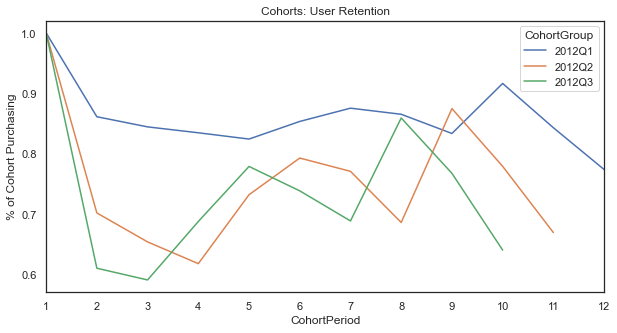

In [398]:
#Line graph of 3 cohort group
user_retention.iloc[:, 0:3].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing')
retention = user_retention.iloc[3,-2]
print(retention)

## Insights

### Customer Lifetime Value has dropped significantly in 2014

In [457]:
dfs

,Year,APV,APFR,Retention,CLTV
0,2012,51.429331,14.141839,0.700000,1037.122599
1,2013,51.711069,12.498668,0.760000,1471.523492
2,2014,52.260376,10.172448,0.679389,652.945875


Text(0, 0.5, 'Dollars')

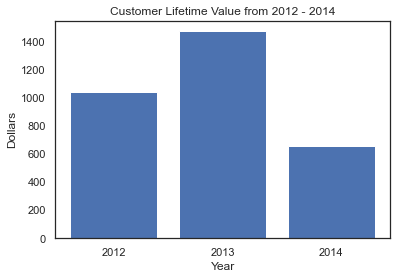

In [459]:
CLTP_P = dfs['CLTV']
Y = dfs['Year']
plt.bar(Y, CLTP_P)
plt.title('Customer Lifetime Value from 2012 - 2014')
plt.xlabel('Year')
plt.ylabel('Dollars')

The Customer Lifetime Value takes into account the three elements of the RFM model: customer purchase frequency (F), average purchase value (MV) and retention (R) to help us understand on a macro point of view how the company performed. 
<br>**In 2014, the CLTV dropped significantly due to the decrease in the two variables:**
<br>1. Average Purchase Frequency Rate (APFR): This is the key goal of the analysis to understand if the Loyalty Campaign actually helpped increase the purchase frequency. However, the APFR dropped to a new low in 2014, indicating that the campaign might not work as expected.
<br>2. Retention Rate: The customer retention also dropped in 2014, indicating less return customers.

### RFM Analysis reveals that the campaign played a limited role in increasing purchase frequency

Text(0, 0.5, 'revenue lift rate (%)')

<Figure size 1080x720 with 0 Axes>

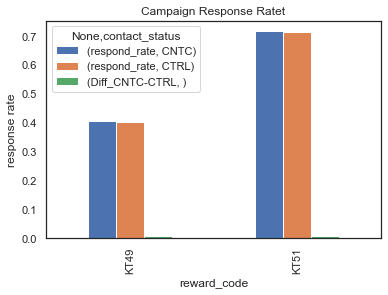

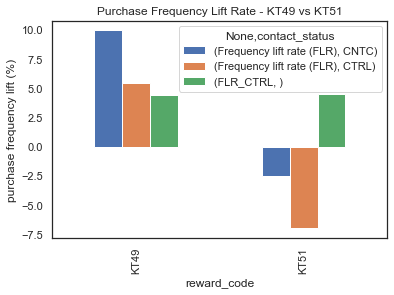

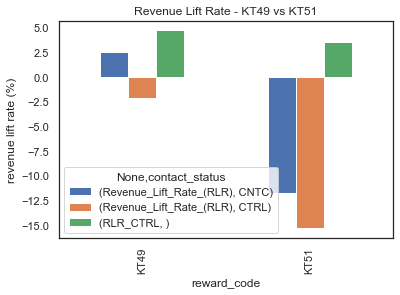

In [542]:
plt.figure(figsize=(15,10))
Rtable.plot(kind='bar')
plt.title('Campaign Response Rate')
plt.ylabel('response rate')

table.plot(kind='bar')
plt.title('Purchase Frequency Lift Rate - KT49 vs KT51')
plt.ylabel('purchase frequency lift (%)')

Mtable.plot(kind='bar')
plt.title('Revenue Lift Rate - KT49 vs KT51')
plt.ylabel('revenue lift rate (%)')

1. **Recency**: The purchase recency has increased both in the KT49 and KT51 customer segments, with 70& of customers in KT51 segment re-purchased. However, the graph indicated that there's no much differeces in terms od customer respond rate, indicating that the campaign failed to increase the purchase recency. Other reasons such as seasonality have led to the increase. 
2. **Frequency**: The customer segment KT49 resulted in an increse in purchase frequency, while KT51 saw a decrease, meaning the purchase frequency for the segment KT51 during the campaign was actually lower than the pre-campaign period. Through the difference-in-differences analysis, the campaign seemed to have increased purchase frequency. However, the regression analysis indicated that there's very weak statistical significance that the campaign is correlated with the frequemcy lift. 
3. **Monetary Value**: This metric had the worst performance during the campaign period. Only the revenue of CNTC group from KT49 segment increased slightly and the rest all had negative revenue lift. Although the campaign appeared to have increased the  revenue lift rate, the regression analysis again indicated that there's no correlation between the campaign and the revenue lift.  

### Campaign ROI

In [596]:
dfr

,Segment,GM,COST,ROI
0,ALL,129229.806464,329494.25,-60.800
1,KT49,88050.158890,146492.25,-39.894
2,KT51,41179.647574,183002.00,-77.498


Text(0, 0.5, 'ROI (%)')

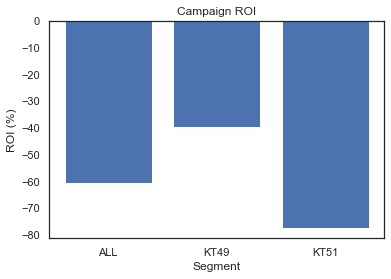

In [598]:
SEG = dfr['Segment']
ROIP = dfr['ROI']
plt.bar(SEG, ROIP)
plt.title('Campaign ROI')
plt.xlabel('Segment')
plt.ylabel('ROI (%)')

The Overall Campaign ROI is negative 60%, with KT49 being -40% and KT51 being 77%, assuming no campaign cost other than the bonus leaf expenditure. The ROI result indicates that the company should not repeat the campaign.

### Retention Rate

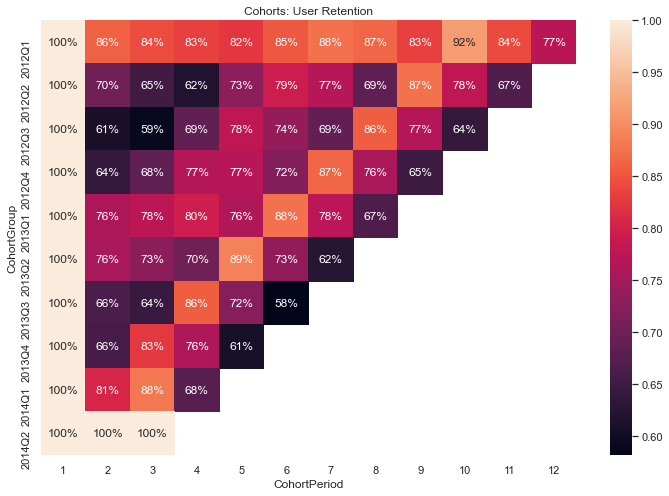

In [601]:
#heatmap
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

During the time when the lotalty campaign was executed, customer retention per quarter did not increse. As the previous analysis reveals that the campaign has no correlation with purchase recency and frequency. The decrease in retention is probably not driven by the campaign. More investigation is required to understand the recreasing trend of retention. 